# Desde cero para un primer modelo de Fast.ai

Importamos todos los paquetes necesarios. 

Vamos a trabajar con la librería [fastai V1](http://www.fast.ai/2018/10/02/fastai-ai/) que encapsula a [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163) para volverlo mas facil de programar

Tambien la libreria de [panda](https://pandas.pydata.org/)

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Obtencion de los datos y clasificacion

En esta etapa recuperaremos los nombres de los archivos para luego combinarlo con el resgistro de anotationes para obtener su clasification.

Obtenemos y definimos nuetro directorio de set de datos.

In [3]:
path = Path('Dataset')
path_annot = path/'annotations'
path_img = path/'images'
path.ls()

[PosixPath('Dataset/images'), PosixPath('Dataset/annotations')]

Recuperamos los nombres de las imagenes.

In [4]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('Dataset/images/ISIC_0027857.jpg'),
 PosixPath('Dataset/images/ISIC_0032409.jpg'),
 PosixPath('Dataset/images/ISIC_0032198.jpg'),
 PosixPath('Dataset/images/ISIC_0032760.jpg'),
 PosixPath('Dataset/images/ISIC_0030711.jpg')]

Obtenemos del archivo de anotationes solo 2 datos importantes, el nombre del archivo .JPG y su clasificacion.
Tambien reducire la cantidad de imagenes para poder ejecutarse con menor tiempo. Pueden ustedes tambien variar la cantidad segun la capacidad de la maquina utilizada.

In [5]:
df = pd.read_csv(path_annot/'HAM10000_metadata.csv', usecols =['image_id', 'dx']) # recuperacion de los datos del CVS
#df2 = df.sample(frac = 0.10) # Reducion de cantidad de imagenes.
filters = ['nv', 'bkl', 'bcc']
df2 = df.loc[df['dx'].isin(filters)] # filtramos 3 categorias
df2.head()

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


Creamos un [DataBunch](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_df) desde un DataFrame con el metodo from_df().

**¿Que es un DataBunch?**
En fastai el objeto que contiene los datos que necesitamos para alimentar una red neuronal se llama DataBunch. Esto se llama 'bunch' porque agrupa varias clases de PyTorch en una sola. En PyTorch hay dos objetos de datos primarios: 
- el DataSet (que contiene todos los elementos de datos junto con su(s) etiqueta(s) asociada(s))
- el DataLoader (que da porciones de los elementos del DataSet al modelo en "lotes"). 

Para un problema típico de aprendizaje supervisado necesitamos un "conjunto de entrenamiento" y un "conjunto de validación", con un DataLoader y un DataSet separados para cada uno. Tambien tenemos que saber que es necesario un'set de prueba', el cual ignoraremos aquí por simplicidad. Todos ellos están incluidos DataBunch.

Indicamos principalmente en nuestro metodo:
- path : Nuestra path de imagenes.
- df : Nuestro DataFrame, en nuestro caso tome el reducido df2.
- valid_pct : El porcentaje del set de datos que utilisaremos como conjunto de validación y entrenamiento.
- Redimensionar las imágenes que estamos importando para que todas sean del mismo tamaño.
- bs : Tamaño del lote (Tener en cuenta la capacidad de la GPU, puede reducirlo si necesario a 16)

In [6]:
data = ImageDataBunch.from_df(path=path_img, df=df2, size=224, suffix='.jpg',
    ds_tfms=get_transforms(), bs=32).normalize(imagenet_stats)

Visualizamos algunas imagenes para estar seguro de la recuperation de los datos.

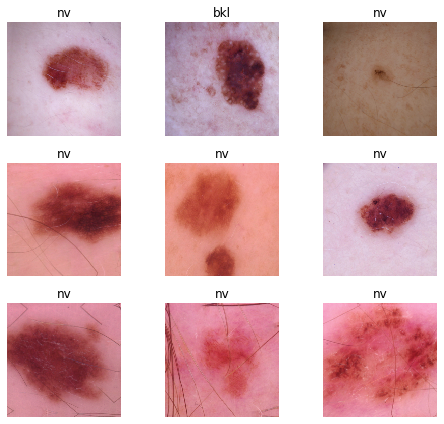

In [7]:
data.show_batch(rows=3, figsize=(7,6))

Visualizamos igualmente las clases obtenidas del archivo CVS.

In [8]:
print(data.classes)
len(data.classes),data.c

['bcc', 'bkl', 'nv']


(3, 3)

## Entrenamiento: resnet34

Para empezar, no entrenamos un modelo de red desde cero. Utilizaremos una red [red neuronal convolucional](http://cs231n.github.io/convolutional-networks/) (CNN) ya pre-entrenada (ResNet-34 en este caso, formado en más de 1 millón de imágenes de ImageNet). Reutilizaremos este conocimiento y reemplazaremos la cabeza del modelo con un nuevo conjunto de capas completamente conectadas dedicadas a nuestra tarea de clasificación.

Entrenaremos por 4 épocas (4 ciclos a través de todos nuestros datos)y seguiremos nuestro progreso especificando el error_rate como una métrica.

Indicamos principalmente:
- data : Es nuestro DataBrunch.
- modelo : La red pre-entrenada que sera una resnet.
- metrics : La metrica de determinacion del error.


In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Iniciamos el entrenamos de nuestro modelo y ademas tendremos automaticamente la salida de la metrica en cada cyclo.

In [10]:
learn.model
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.489486,0.327205,0.128082,18:03
1,0.352518,0.278813,0.114251,18:15
2,0.300755,0.252833,0.104630,09:05
3,0.262318,0.246269,0.097414,09:31


In [11]:
learn.save('stage-1')

## Resultados

De los 4 ciclos ejecutados podemos encontrar cuáles fueron las categorías que el modelo más confundió entre sí. Intentaremos ver si lo que el modelo predijo era razonable o no.  

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

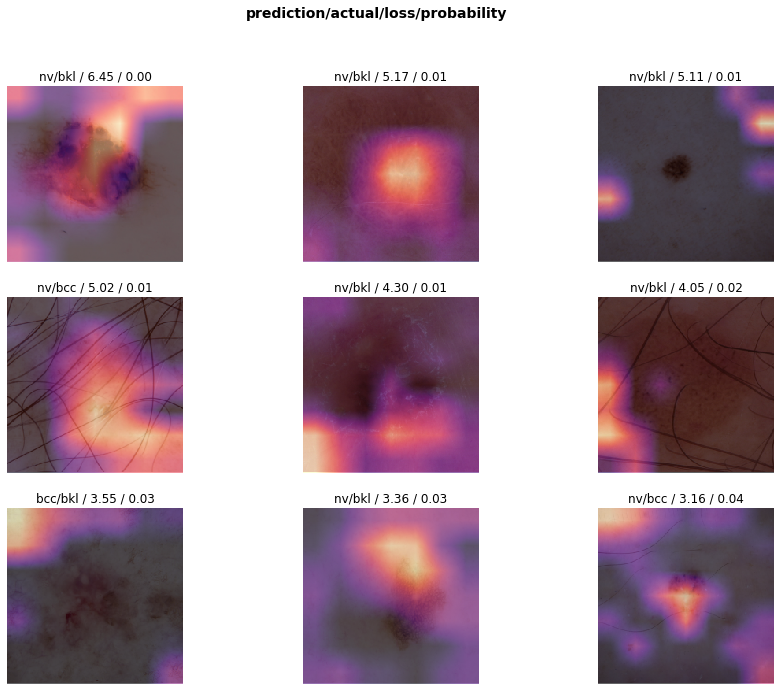

In [13]:
interp.plot_top_losses(9, figsize=(15,11))

Cuando trazamos la matriz de confusión, podemos ver que la distribución está muy sesgada: el modelo comete los mismos errores una y otra vez, pero rara vez confunde a otras categorías. Esto sugiere que le resulta difícil distinguir algunas categorías específicas entre sí; esto es normal.

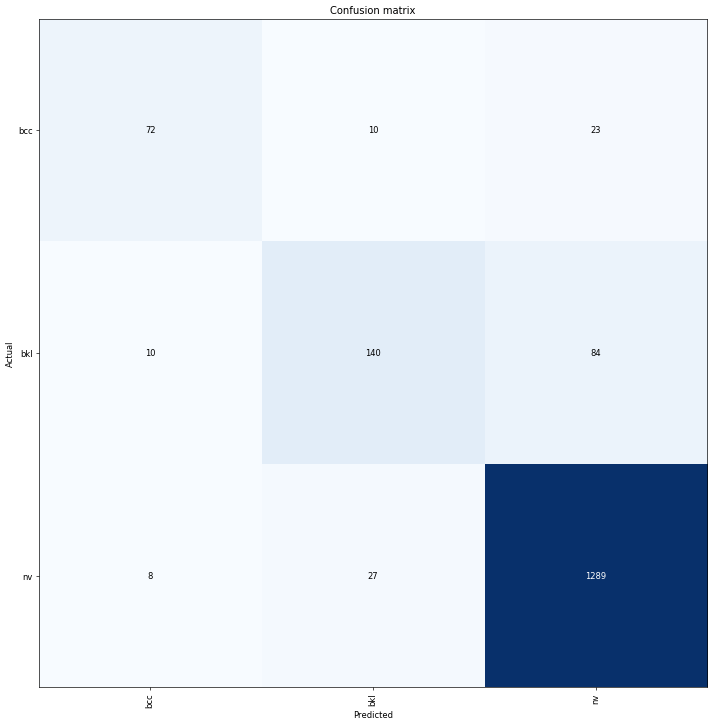

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Listamos las relaciones mas confusas para analizar.

In [15]:
interp.most_confused(min_val=2)

[('bkl', 'nv', 84),
 ('nv', 'bkl', 27),
 ('bcc', 'nv', 23),
 ('bcc', 'bkl', 10),
 ('bkl', 'bcc', 10),
 ('nv', 'bcc', 8)]

## Unfreezing, fine-tuning, and learning rates

Cuando pensamos que nuestro modelo está funcionando como esperamos, volvemos a cargar nuestro modelo (unfreeze) y entrenaremos un poco más para ver si el error se reduce.

In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.271767,0.219348,0.086590,12:29


In [18]:
learn.load('stage-1');

El método learn.lr_find() le ayuda a encontrar un ritmo de aprendizaje óptimo. Utiliza la técnica desarrollada en el documento de 2015 [Cyclical Learning Rates](https://arxiv.org/abs/1506.01186) for Training Neural Networks, donde simplemente seguimos aumentando el ritmo de aprendizaje desde un valor muy pequeño, hasta que la pérdida deja de disminuir. Podemos graficar la velocidad de aprendizaje entre lotes para ver cómo se ve esto.

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


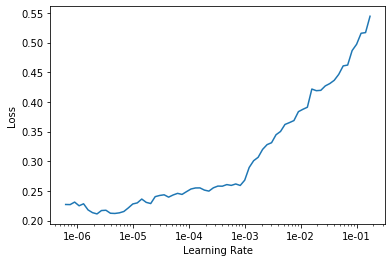

In [20]:
learn.recorder.plot()

Como se desprende de la grafica de arriba, queremos encontrar un ritmo de aprendizaje que nos proporcione el menor índice de pérdida. Como regla general, encontramos el punto más bajo de la curva antes de que la pérdida se dispare de nuevo y vamos una magnitud hacia la izquierda 1e-03 en este caso). Luego entrenamos el modelo durante 2 ciclos usando el método fit_one_cycle(). La política de un ciclo es una gran técnica para establecer los hiperparámetros (velocidad de aprendizaje, impulso y caída de peso) de una manera que permite entrenar modelos complejos de forma rápida y eficiente. En esencia, queremos que la mayor velocidad de aprendizaje posible (determinada por lr_find()) explore el espacio de la característica eficientemente. Segundo, la velocidad de aprendizaje cambia en un ciclo desde un valor bajo hasta el máximo y luego vuelve a bajar. Se observó que las altas tasas de aprendizaje en la mitad de un ciclo también actúan como un método de regularización que previene el sobreajuste. 

In [21]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.397783,0.287705,0.110042,12:20
1,0.259028,0.190598,0.071557,12:22


Bueno el resultado es mucho mejor.

## Training: resnet50

Ahora sabiendo un poco las etapas podemos entrenaremos de la misma manera que antes pero en lugar de usar resnet34 como columna vertebral usaremos resnet50 (resnet34 es una red residual de 34 capas mientras que resnet50 tiene 50 capas. Puede aprender los detalles en el[resnet paper](https://arxiv.org/pdf/1512.03385.pdf).

Básicamente, resnet50 funciona mejor porque es una red más profunda con más parámetros. Veamos si podemos lograr un mayor rendimiento aquí. Para facilitarlo, usemos también imágenes más grandes, ya que de esta manera la red puede ver más detalles. Reducimos un poco el tamaño del lote ya que, de lo contrario, esta red más grande necesitará más memoria en la GPU.

In [ ]:
data = ImageDataBunch.from_df(path=path_img, df=df2, size=299, suffix='.jpg',
    ds_tfms=get_transforms(), bs=32).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('stage-1-50')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

## Conclusion

Como se muestra, se necesita relativamente poco esfuerzo para construir un clasificador de imágenes personalizado capaz de tener una buena precisión. Gracias a usar una biblioteca de aprendizaje profundo como fastai, una arquitectura de modelos pre-entrenada, un conjunto de datos de tamaño razonable y algunos trucos!